# Holiday Effect Strategy - Signal Analysis

Generate and analyze trading signals based on holiday calendar.

In [16]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from signal_generator import SignalGenerator
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Generate Signals

In [7]:
# Initialize signal generator
signal_gen = SignalGenerator('config.yaml')
trading_calendar = pd.date_range(start='2010-01-01', end='2024-12-31', freq='B')
signals, windows = signal_gen.generate_signal_series(trading_calendar)
print(f"Total signals: {len(signals)}")
print(f"Event window signals: {(signals['in_window'] == 1).sum()}")
print(f"Non-event signals: {(signals['in_window'] == 0).sum()}")
signals.head(20)

Total signals: 3913
Event window signals: 275
Non-event signals: 3638


,in_window,event_type
2010-01-01,0,
2010-01-04,0,
2010-01-05,0,
2010-01-06,0,
2010-01-07,0,
2010-01-08,0,
2010-01-11,0,
2010-01-12,0,
2010-01-13,0,
2010-01-14,0,


## 2. Signal Distribution

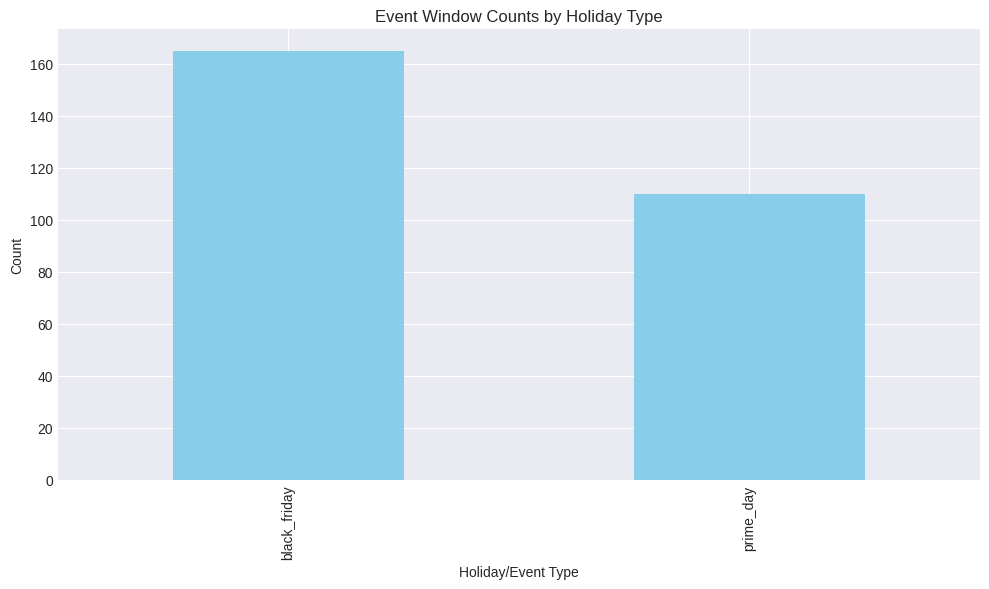

In [9]:
# Signals by event type and window status
signal_counts = signals[signals['in_window'] == 1]['event_type'].value_counts()

fig, ax = plt.subplots(figsize=(10, 6))
signal_counts.plot(kind='bar', ax=ax, color='skyblue')
ax.set_title('Event Window Counts by Holiday Type')
ax.set_ylabel('Count')
ax.set_xlabel('Holiday/Event Type')
plt.tight_layout()
plt.show()

## 3. Forward Returns Analysis

In [ ]:
spy = yf.download('SPY', start='2010-01-01', end='2024-12-31')
spy['Returns'] = spy['Close'].pct_change()
# Align index and join returns to signals
signals = signals.join(spy['Returns'], how='left')
print(signals.columns)  # Confirm 'Returns' now present
# Now calculate forward returns for different holding periods
for days in [1, 3, 5, 10]:
    signals[f'Forward_{days}d'] = signals['Returns'].shift(-days).rolling(days).sum()

# Example: compare event vs non-event periods
event_signals = signals[signals['in_window'] == 1]
non_event_signals = signals[signals['in_window'] == 0]

print("Average Forward Returns:")
for days in [1, 3, 5, 10]:
    event_ret = event_signals[f'Forward_{days}d'].mean()
    non_event_ret = non_event_signals[f'Forward_{days}d'].mean()
    print(f"{days}-day: Event={event_ret:.4%}, Non-Event={non_event_ret:.4%}, Diff={event_ret - non_event_ret:.4%}")

Index(['in_window', 'event_type'], dtype='object')
            in_window event_type
2010-01-01          0           
2010-01-04          0           
2010-01-05          0           
2010-01-06          0           
2010-01-07          0           
DatetimeIndex(['2010-01-01', '2010-01-04', '2010-01-05', '2010-01-06',
               '2010-01-07', '2010-01-08', '2010-01-11', '2010-01-12',
               '2010-01-13', '2010-01-14',
               ...
               '2024-12-18', '2024-12-19', '2024-12-20', '2024-12-23',
               '2024-12-24', '2024-12-25', '2024-12-26', '2024-12-27',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', length=3913, freq='B')
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Index(['in_window', 'event_type', 'Returns'], dtype='object')
Average Forward Returns:
1-day: Event=0.1071%, Non-Event=0.0532%, Diff=0.0540%
3-day: Event=0.3657%, Non-Event=0.1547%, Diff=0.2110%
5-day: Event=0.7040%, Non-Event=0.2256%, Diff=0.4784%
10-day: Event=1.1278%, Non-Event=0.4099%, Diff=0.7178%


## 4. Cumulative Signal Performance

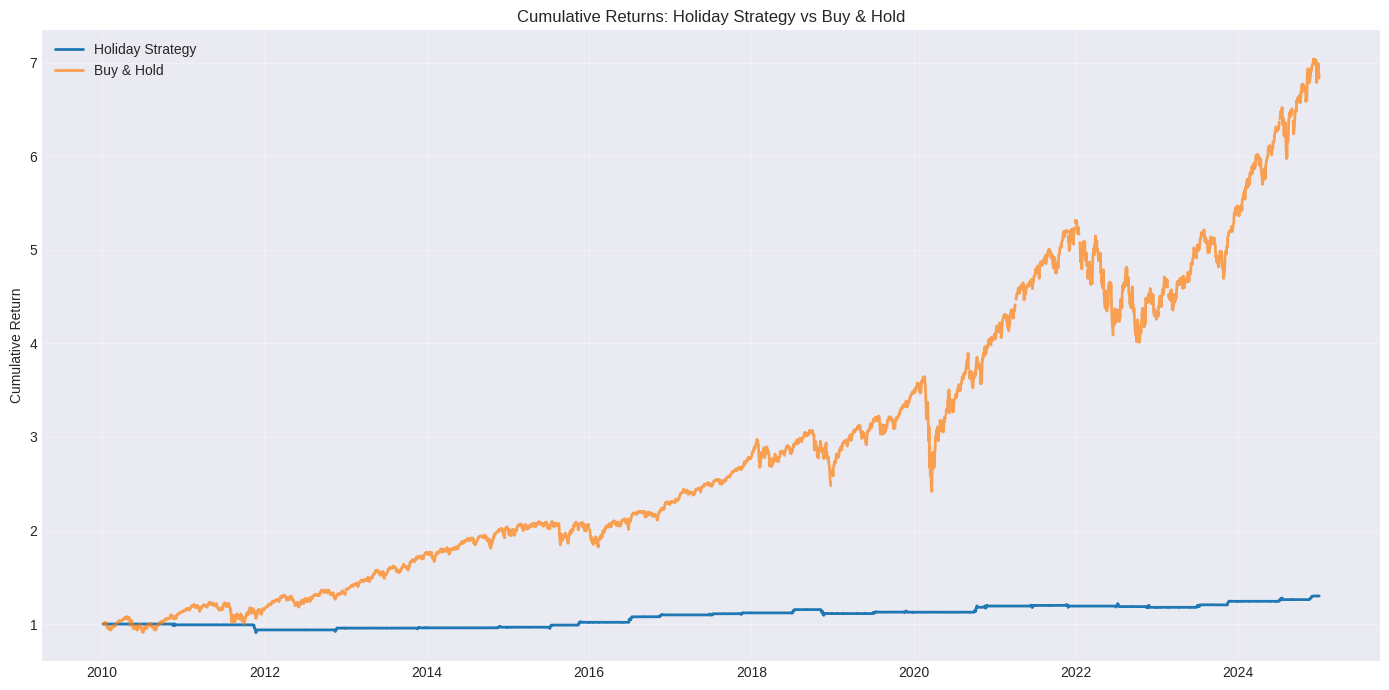

In [17]:
# Calculate strategy returns using 'in_window' as the signal (1 for event window, 0 for non-event)
signals['Strategy_Returns'] = signals['in_window'].shift(1) * signals['Returns']
signals['Cumulative_Strategy'] = (1 + signals['Strategy_Returns']).cumprod()
signals['Cumulative_BuyHold'] = (1 + signals['Returns']).cumprod()

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(signals.index, signals['Cumulative_Strategy'], label='Holiday Strategy', linewidth=2)
ax.plot(signals.index, signals['Cumulative_BuyHold'], label='Buy & Hold', linewidth=2, alpha=0.7)
ax.set_title('Cumulative Returns: Holiday Strategy vs Buy & Hold')
ax.set_ylabel('Cumulative Return')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()